In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
%matplotlib inline

# Open the file:
data = rasterio.open("example.tif")

# Plot band 1
# show((data, 1), cmap='terrain')

In [2]:
from shapely.geometry import box

minx, miny = 361044.2,619013.4 
maxx, maxy = 383132.1,635928.0
bbox = box(minx, miny, maxx, maxy)

In [3]:
import geopandas as gpd
from fiona.crs import from_epsg

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(27700))

In [4]:
geo = geo.to_crs(crs=data.crs.data)

In [5]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [6]:
coords = getFeatures(geo)
coords

[{'type': 'Polygon',
  'coordinates': [[[383132.1, 619013.4000000013],
    [383132.1, 635928.0000000001],
    [361044.1999999998, 635927.999999999],
    [361044.1999999998, 619013.4],
    [383132.1, 619013.4000000013]]]}]

In [7]:
from rasterio.mask import mask

out_img, out_transform = mask(data, shapes=coords, crop=True)

In [8]:
out_meta = data.meta.copy()
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 29819,
 'height': 21992,
 'count': 2,
 'crs': CRS.from_dict(init='epsg:27700'),
 'transform': Affine(10.0, 0.0, 154580.59591206638,
        0.0, -10.0, 693426.1972031946)}

In [9]:
epsg_code = int(data.crs.data['init'][5:])
epsg_code

27700

In [10]:
import pycrs

out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
               )

In [11]:
out_tif = r"clipped_example.tif"

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

In [12]:
clipped = rasterio.open(out_tif)

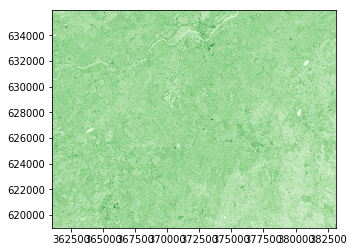

In [13]:
show((clipped, 1), cmap='Greens')

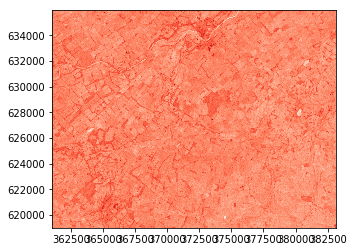

In [14]:
show((clipped, 2), cmap='Reds')

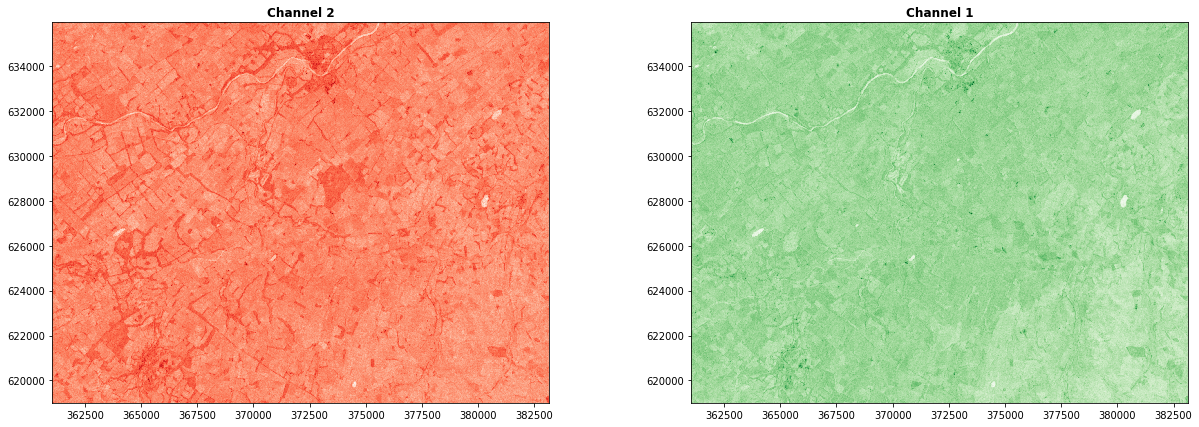

In [27]:
from matplotlib import pyplot

fig, (axr, axg) = pyplot.subplots(1,2, figsize=(25,20))
show((clipped, 1), ax=axg, cmap='Greens', title='Channel 1')
show((clipped, 2), ax=axr, cmap='Reds', title='Channel 2')

/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


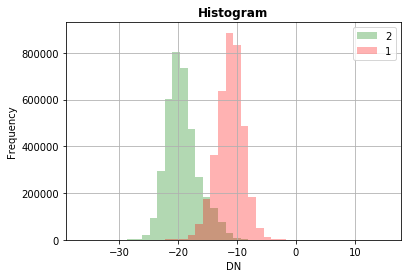

In [15]:
from rasterio.plot import show_hist

#show_hist(data, bins=50, lw=0.0, stacked=False, alpha=0.3,
#          histtype='stepfilled', title="Histogram")
show_hist(clipped, bins=40, lw=0.0, stacked=False, alpha=0.3,
          histtype='stepfilled', title="Histogram")

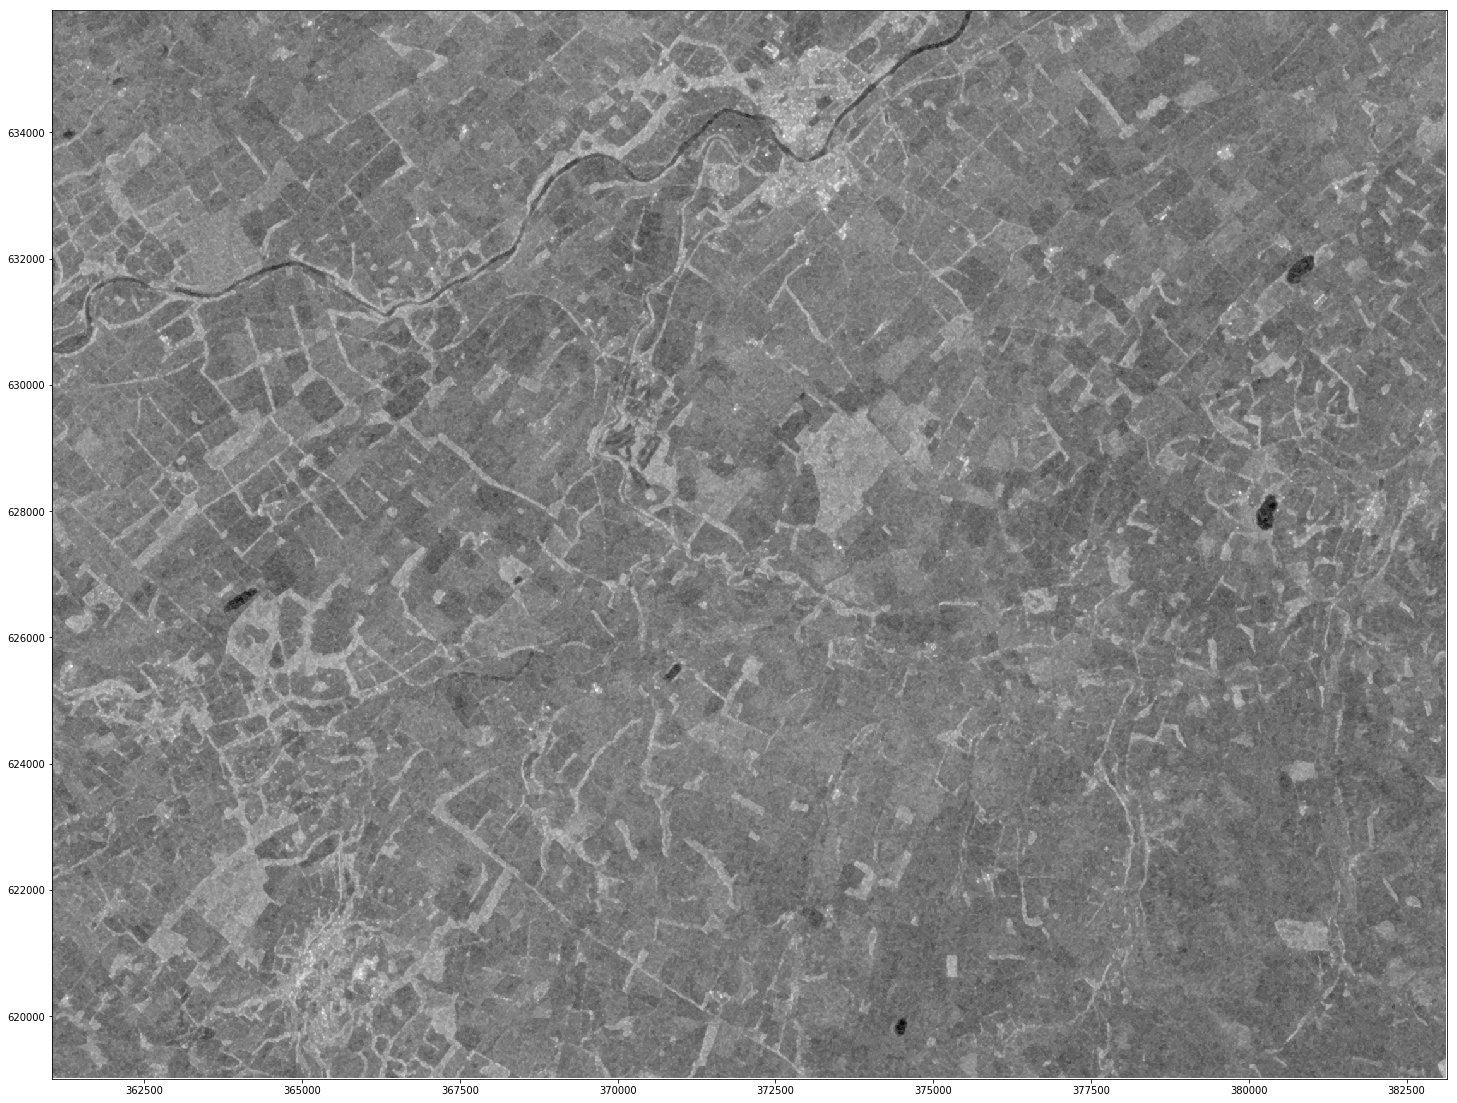

In [43]:
fig, ax = pyplot.subplots(1, figsize=(25, 20))
show((clipped, 2), cmap='Greys_r', interpolation='none', ax=ax)
pyplot.show()

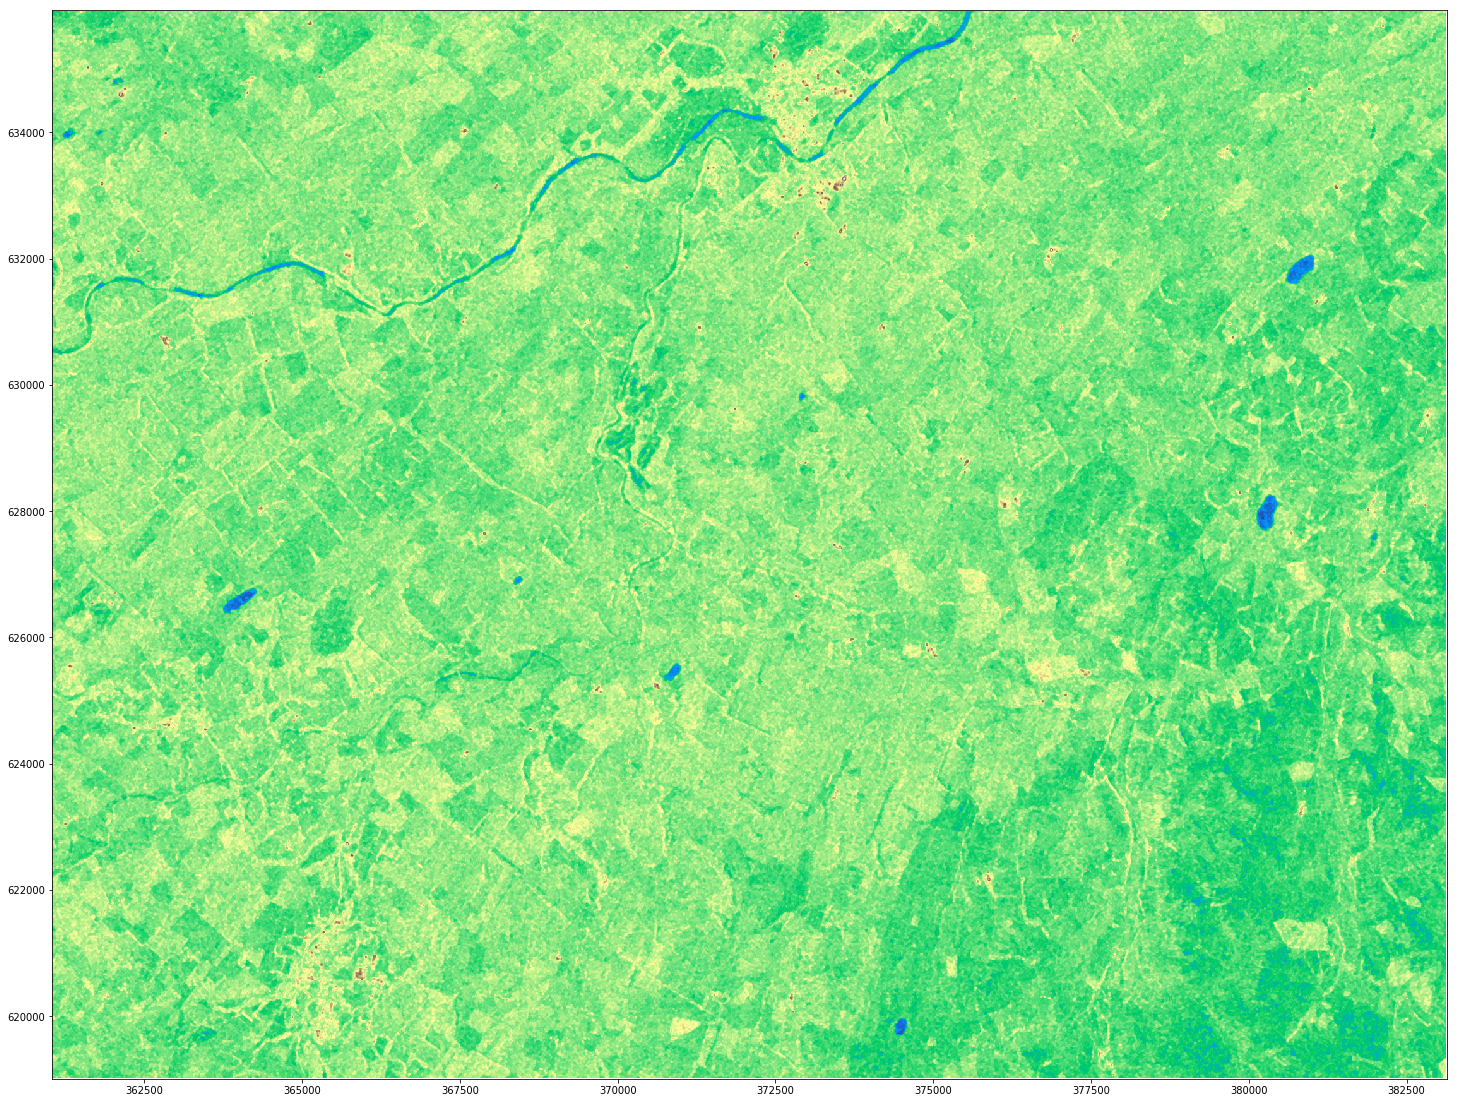

In [42]:
fig, ax = pyplot.subplots(1, figsize=(25, 20))
show((clipped), cmap='terrain', ax=ax)
pyplot.show()

In [62]:
import geopandas as gpd

shapefile = gpd.read_file('fields.shp')
print(shapefile)

                                              geometry
0    (POLYGON ((364507.67095 623796.49868, 364509.5...
1    (POLYGON ((364884.55602 623773.88824, 364901.3...
2    POLYGON ((364929.18 623977.0699999999, 364942....
3    POLYGON ((365941.7214139803 623692.1773446318,...
4    POLYGON ((365390.61 623379.3100000001, 365368....
5    (POLYGON ((366027.78 623472.71, 366023.37 6234...
6    POLYGON ((365842.804 623796.088, 365818.743006...
7    POLYGON ((365609.4 623824.4, 365604.24 623809....
8    POLYGON ((364967.19 623924.7, 364997.38 623941...
9    POLYGON ((365100.05 623876.4, 365093.238 62388...
10   POLYGON ((364799.9135399146 624139.2180385184,...
11   (POLYGON ((365021.457 624452.711, 365007.901 6...
12   POLYGON ((365079.04276 624180.4818899999, 3650...
13   (POLYGON ((365577.8676 624289.75877, 365577.66...
14   POLYGON ((365571.078158778 624318.5784264239, ...
15   (POLYGON ((364816.457 624512.344, 364821.551 6...
16   POLYGON ((366028.68 624000, 366020.978 623993....
17   (POLY

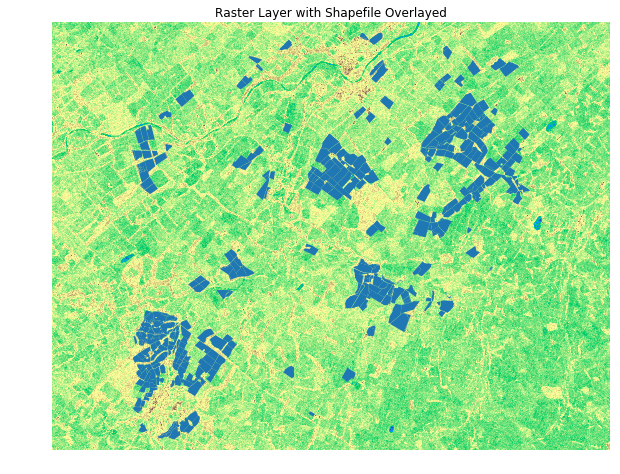

In [68]:
fig, ax = pyplot.subplots(figsize=(10, 8))
show((clipped, 2), cmap='terrain', ax=ax)
shapefile.plot(ax=ax, alpha=1)
ax.set_title("Raster Layer with Shapefile Overlayed")
ax.set_axis_off()

In [143]:
print(shapefile[58:59])

                                             geometry
58  POLYGON ((372010.72 631528.101, 372021.16 6315...


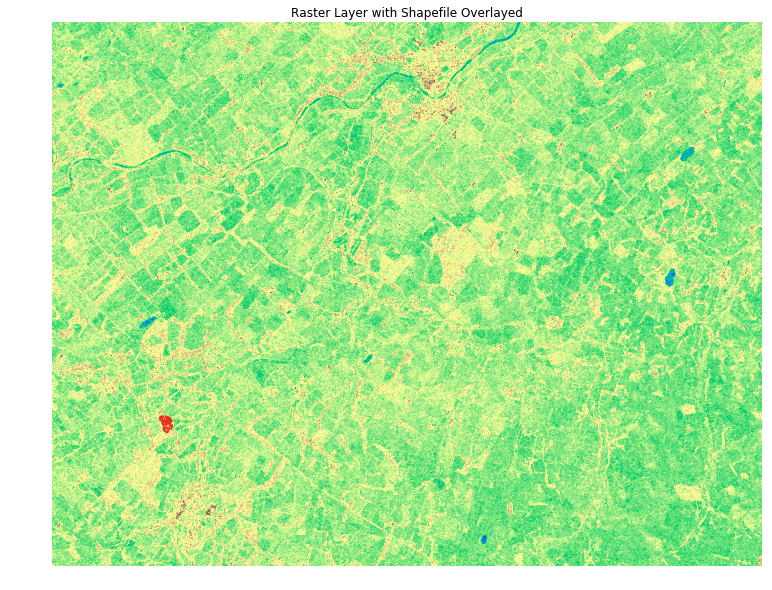

In [147]:
fig, ax = pyplot.subplots(figsize=(15, 10))
show((clipped, 2), cmap='terrain', ax=ax)
shapefile[100:101].plot(ax=ax, color='red', alpha=0.8)
ax.set_title("Raster Layer with Shapefile Overlayed")
ax.set_axis_off()

In [96]:
from shapely.geometry import mapping

# create geojson object from the shapefile imported above
field_geojson = mapping(shapefile['geometry'][58])
field_geojson

{'type': 'Polygon',
 'coordinates': (((372010.72, 631528.101),
   (372021.16, 631530.18),
   (372023.284, 631529.101),
   (372028.52, 631526.44),
   (372039.337, 631520.506),
   (372045.809, 631516.955),
   (372047.24, 631516.17),
   (372056.916, 631510.163),
   (372071.58, 631501.06),
   (372073.027, 631499.923),
   (372074.045, 631499.124),
   (372082.17, 631492.74),
   (372089.873, 631486.251),
   (372101.071, 631476.817),
   (372104.32, 631474.08),
   (372105.421, 631473.05),
   (372120.325, 631459.115),
   (372135.229, 631445.18),
   (372150.124, 631431.253),
   (372152.94, 631428.62),
   (372165.385, 631417.725),
   (372180.736, 631404.286),
   (372185.54, 631400.08),
   (372196.205, 631390.974),
   (372211.714, 631377.733),
   (372215.074, 631374.864),
   (372218.03, 631372.34),
   (372227.233, 631364.491),
   (372242.754, 631351.253),
   (372258.276, 631338.015),
   (372273.798, 631324.777),
   (372289.319, 631311.539),
   (372290.81, 631310.268),
   (372292.25, 631309.04),
   

In [136]:
from rasterio.mask import mask
from rasterio.plot import plotting_extent

field_crop, field_crop_affine = mask(clipped, [field_geojson], crop=True, indexes=[1])

# Create spatial plotting extent for the cropped layer
field_extent = plotting_extent(field_crop[0], field_crop_affine)

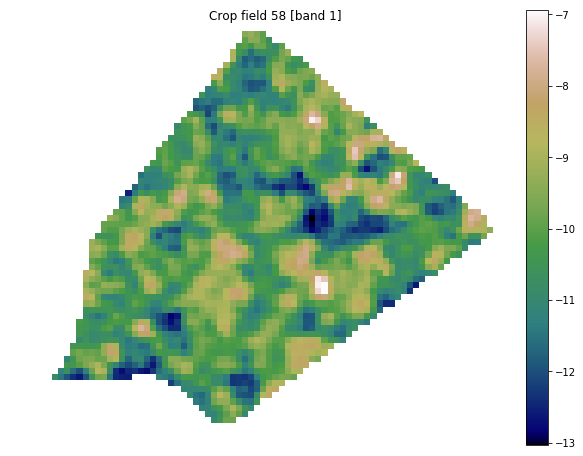

In [137]:
# Plot your data
fig, ax = pyplot.subplots(figsize=(10, 8))
image = ax.imshow(field_crop[0],
          extent=field_extent,
          cmap='gist_earth')
fig.colorbar(image, ax=ax, orientation='vertical');
ax.set_title("Crop field 58 [band 1]")
ax.set_axis_off()

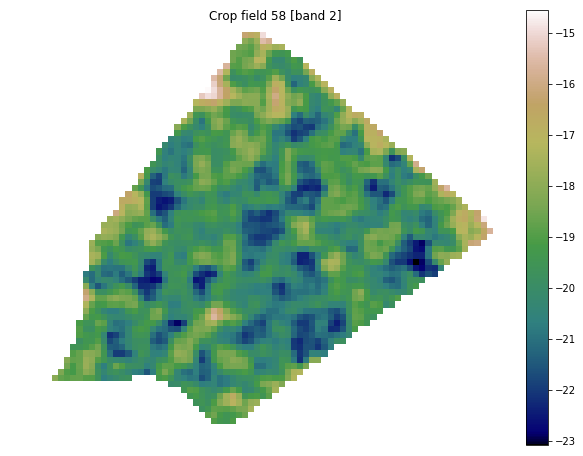

In [138]:
field_crop, field_crop_affine = mask(clipped, [field_geojson], crop=True, indexes=[2])

# Create spatial plotting extent for the cropped layer
field_extent = plotting_extent(field_crop[0], field_crop_affine)

# Plot your data
fig, ax = pyplot.subplots(figsize=(10, 8))
image = ax.imshow(field_crop[0],
          extent=field_extent,
          cmap='gist_earth')
fig.colorbar(image, ax=ax, orientation='vertical');
ax.set_title("Crop field 58 [band 2]")
ax.set_axis_off()